In [6]:
from pomegranate import *
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
%matplotlib inline

## Code Provided for Exercise

In [7]:
def state_names(pomegranate_viterbi_output):
    # just return the state names from a pomegranate Viterbi call,
    # stripping off start
    return [state.name for i, state in pomegranate_viterbi_output[1]][1:] 

In [8]:
def pp(O, Q=None, stateSymbol=None, lineWidth=72):
    """ Pretty print discrete observation sequences (and state paths). Assumes
        observations and state.name (unless stateSymbols is supplied) are
        single-character.
             
        stateSymbol is an optional dictionary mapping state.names to single
        character strings.

        Usage: pp(O, Q, {fair:' ',unfair:'U'})  produces 
        1       123423123245621432...
                  UUU         UU ...
    """
    T = len(O)
    for i in range(0, len(O), lineWidth):
        print ("%6d  %s" % (i+1, "".join(str(o) for o in O[i:min(i+lineWidth,T)])))
        if Q is not None:
            if stateSymbol is None:
                print ("        %s" % "".join(Q[i:min(i+lineWidth,T)]))
            else:
                print ("        %s" % "".join([stateSymbol[s] for s in Q[i:min(i+lineWidth,T)]]))
        print()

In [9]:
m = State(BernoulliDistribution(0.9), name='m')
f = State(BernoulliDistribution(0.1), name='f')
model = HiddenMarkovModel()
model.add_states(m,f)

# pomegranate adds a designated start state with
# transitions to the real states in the model
# instead of a initial distribution

model.add_transition(model.start, f, 0.5)
model.add_transition(model.start, m, 0.5)

model.add_transition(f, f, 0.99)
model.add_transition(f, m, 0.01)
model.add_transition(m, f, 0.04)
model.add_transition(m, m, 0.96)
model.bake() # Call, when all states and transitions are added.

O = model.sample(length=720)
Q = state_names(model.viterbi(O))
pp(O,Q,stateSymbol={'f':'f', 'm':'m'}, lineWidth=100)

     1  0000000010000100000010000001000000000010111011111000100000000000000000101000000000000000010000000000
        ffffffffffffffffffffffffffffffffffffffffmmmmmmmmmfffffffffffffffffffffffffffffffffffffffffffffffffff

   101  0001000001000000000000100000000000000000000000010100000000000000100000000000010000001011111111111101
        ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffmmmmmmmmmmmmmm

   201  1111001111111100000000000111111110000000000000000001001000100001001101111111100000000010000000000011
        mmmmmmmmmmmmmmfffffffffffmmmmmmmmfffffffffffffffffffffffffffffffffmmmmmmmmmmmfffffffffffffffffffffff

   301  1000000000110011111000000000000000000000000000000100000000010100000010000000010000100100000000010000
        ffffffffffffffmmmmmfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff

   401  0101111110010111101111111010000000000000001000011101001000000000000000010010011000000000100000000000
        fffmmmm

## Part 1

In [10]:
df = pd.read_table('hyb.txt', header=None)

In [11]:
f_patient = df.iloc[:,1:3]

In [12]:
f_patient['chromosomal pos'] = f_patient[1]
f_patient['ratio'] = f_patient[2]

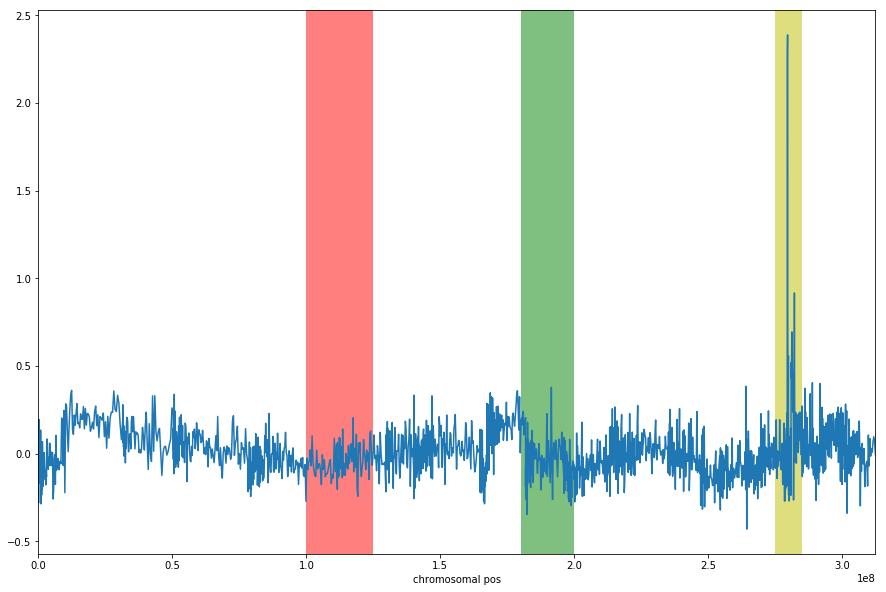

In [9]:
f_patient.plot(x='chromosomal pos',y='ratio',figsize=(15,10), legend=False)
a,b,c,d,e,f = 2.75*1e8, 2.85*1e8, 1.8*1e8, 2*1e8, 1*1e8, 1.25*1e8
plt.axvspan(a, b, color='y', alpha=0.5, lw=0)
plt.axvspan(c, d, color='g', alpha=0.5, lw=0)
plt.axvspan(e, f, color='r', alpha=0.5, lw=0)

<b> Comments </b>

From a visual inspection, there appear to be three different regimes within the data. A duplication regime (in yellow), a normal regime (in red) and a deletion regime (in green).

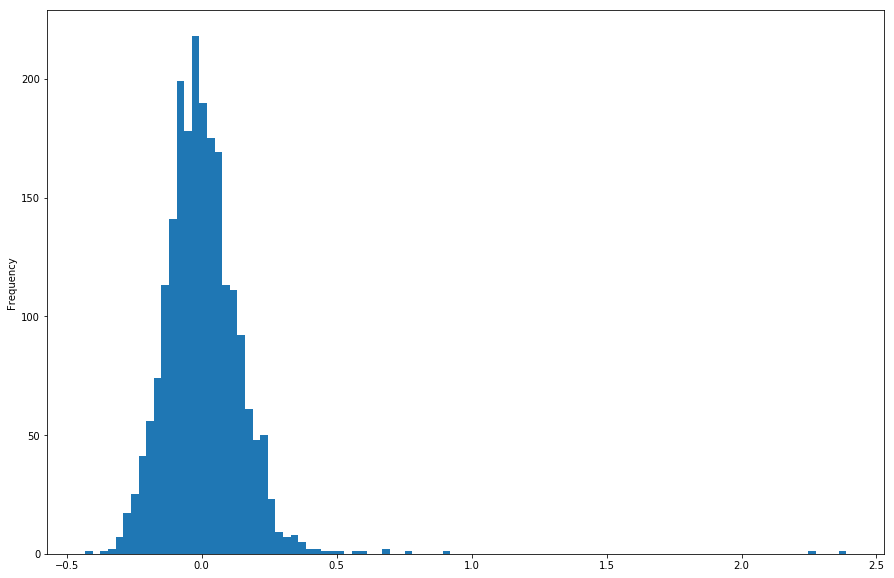

In [10]:
f_patient['ratio'].plot(kind='hist',bins=100,figsize=(15,10))

<b> Comments </b>

The distribution of the ratios appears similar to a standard normal, although there are clear signs of multimodality. In addition, there are some large outliers beyond 2 standard deviations from the standard normal distribution.

Some useful thresholds for each would be:

- The deletion regime should have a mean slightly below 0
- The normal regime should have a mean around 0
- The duplication regime should have a mean above 0

## Part 2

In [13]:
import numpy as np
import json
import seaborn as sns

In [2]:
def params_init(X,n):
    '''
    Initialise emission probabilities using the quantiles of the overall distribution. 
    The data is split into n sections and the mean and variance for each section is calculated.
    
    Returns initialised means and variances as numpy arrays
    '''
    means = {}
    variances = {}
    X_split = {}
    for i in range(0,n):
        X_split[i] = X[(X > X.quantile(q=i/n)) & (X < X.quantile(q=(i+1)/n))]
    for i in range(len(X_split)):
        means[i] = np.mean(X_split[i])
        variances[i] = np.std(X_split[i])**2
    return means, variances

In [3]:
def HMM(N, means, variances):
    '''
    Creates a fully connected HMM with N states with a Gaussian pdf with means and variances as specified by
    the means and variances vectors.
    
    Returns the pomegranate model object
    '''
    #We assume that states will persist most of the time
    x = random.uniform(0.5,1)
    states = [State(NormalDistribution(means[i],variances[i]),
                    name=str(i)) for i in range(0,N)]
    model = HiddenMarkovModel()
    model.add_states(states)
    initialise = [model.add_transition(model.start, states[i], 1/N) for i in range(0,N)]
    same_trans = [model.add_transition(states[k],states[k], x) for k in range(0,N)]
    transitions = [model.add_transition(states[k], states[j], 
                                        (1-x)/N) for (k,j) in itertools.permutations(range(0,N), 2)]
    model.bake()
    return model

In [4]:
def compute_cycle(data, n):
    '''
    Step-wise model creation:
    - Initialise parameters
    - Initialise model
    '''
    means, variances = params_init(data, n)
    return HMM(n,means,variances)

## Part 3

In [19]:
def bw_viterbi(model, data=f_patient, n_repetitions=1000, plot=True):
    model.fit([data['ratio']], algorithm='baum-welch', max_iterations=n_repetitions)
    O = data['ratio']
    Q = state_names(model.viterbi(O))
    data['labels'] = Q
    if plot:
        ax = sns.lmplot(x='chromosomal pos',y='ratio', data=data, hue='labels', 
                        fit_reg=False, size=8.5, aspect=1.5, scatter_kws={"s": 5})
        ax.set(xlabel='Chromosomal Position', ylabel='DNA Ratio', title='Viterbi Segmentation')
    #pp(O,Q)
    #return model
    return json.loads(model.to_json())

In [20]:
def viterbi_plot(model, data):
    ax = sns.lmplot(x='chromosomal pos',y='ratio', data=data, hue='labels', 
                    fit_reg=False, size=8.5, aspect=1.5, scatter_kws={"s": 5})
    ax.set(xlabel='Chromosomal Position', ylabel='DNA Ratio', title='Viterbi Segmentation')

In [21]:
def bw_viterbi_simple(model, data=f_patient):
    model.fit([data], algorithm='baum-welch', max_iterations=1000)
    O = data
    Q = state_names(model.viterbi(O))
    return model, Q
    #pp(O,Q)

## Part 4

### A

An HMM can be defined by (A, B, π), where A is a matrix of state transition probabilities, B is a vector of state emission probabilities and π (a special member of A) is a vector of initial state distributions. The following steps are taken to estimate these parameters:

For the A and π parameters, randomly initialise the HMM (between 0 and 1)

- For A, we initialise knowing that the probabilities of returning to the same state should be rather large (say > 0.5) to create longer sequences. We thus choose a random number between 0.5 and 1 from a uniform distribution over that interval. The remaining probability is then spread equally among remaining states.

- For π, we initialise with an equal (uniform) probability ascribed to each possible hidden state.

We initialise the B parameter by segmenting the training data according to quantiles based on the number of hidden states and estimating the global mean and variance. The B parameter deals with the mean and variances of each state.

We then re-estimate and refine the parameters using the Baum-Welch algorithm. 

### B

In [22]:
np.random.seed(1)

In [23]:
m, v = params_init(f_patient['ratio'],3)

In [24]:
demo = HMM(3, m, v)

In [25]:
fits = [demo.fit([f_patient['ratio']], algorithm='baum-welch', max_iterations=1) for i in range(100)]

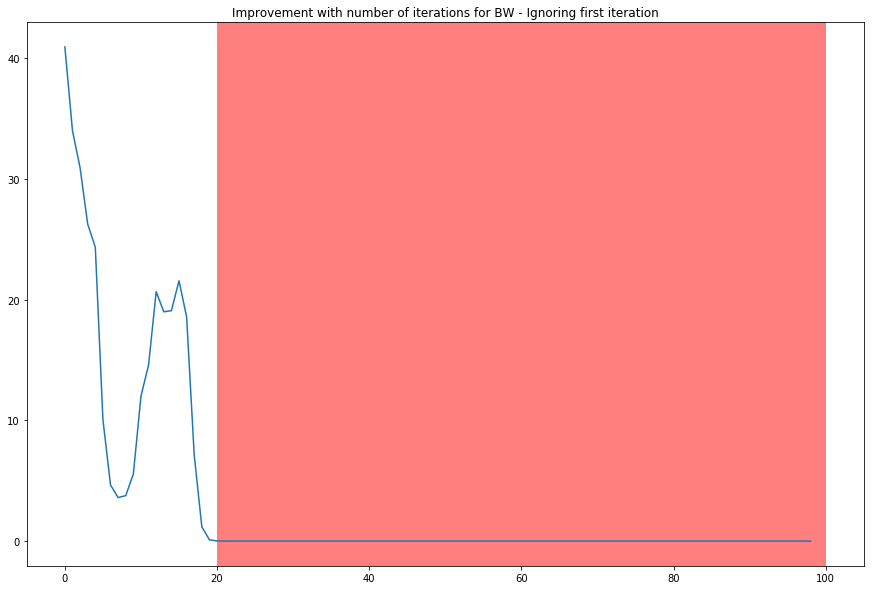

In [26]:
plt.figure(figsize=(15,10))
plt.title('Improvement with number of iterations for BW - Ignoring first iteration')
plt.plot(fits[1:])
plt.axvspan(20, 100, color='r', alpha=0.5, lw=0)

Based on the trajectory of the improvement over the number of iterations, we can see that we only need 20 iterations to reach our local optimum.

### C

In [27]:
models = [compute_cycle(f_patient.ratio, i) for i in range(1,10)]

In [910]:
states_fits = [i.fit([f_patient['ratio']], algorithm='baum-welch', max_iterations=1000) for i in models]

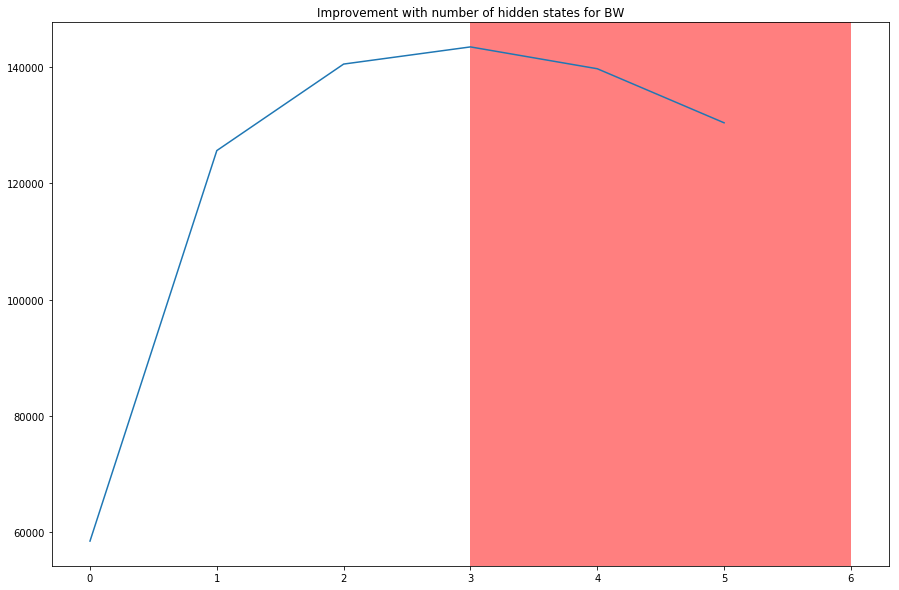

In [911]:
plt.figure(figsize=(15,10))
plt.title('Improvement with number of hidden states for BW')
plt.plot(states_fits)
plt.axvspan(3, 6, color='r', alpha=0.5, lw=0)

Similarly, 3 seems to be appropriate as a cut-off for the number of hidden states. 

In [28]:
m, v = params_init(f_patient.ratio, 3)

In [29]:
mod = HMM(3, m, v)

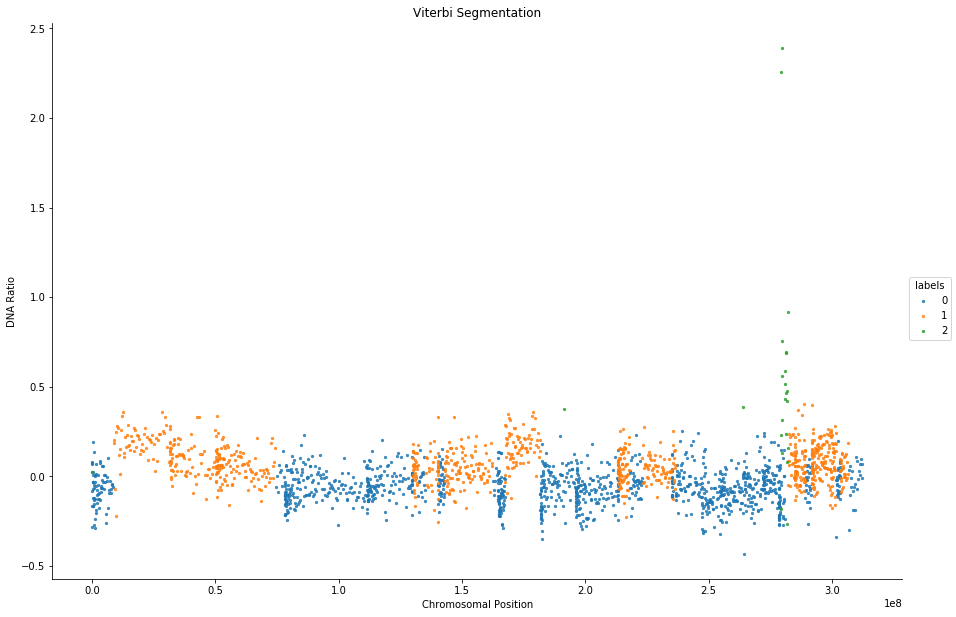

In [30]:
params3 = bw_viterbi(mod, n_repetitions=1000)

## Question 5

### Initialise True Model

In [31]:
m = State(NormalDistribution(-1,2), name='0')
f = State(NormalDistribution(1,5), name='1')
model = HiddenMarkovModel()
model.add_states([m,f])

# pomegranate adds a designated start state with
# transitions to the real states in the model
# instead of a initial distribution

model.add_transition(model.start, f, 0.5)
model.add_transition(model.start, m, 0.5)

model.add_transition(f, f, 0.99)
model.add_transition(f, m, 0.01)
model.add_transition(m, f, 0.04)
model.add_transition(m, m, 0.96)
model.bake() # Call, when all states and transitions are added.

random.seed(777)
O = model.sample(length=720)
Q = state_names(model.viterbi(O))
print(Q)
#pp(O,Q,stateSymbol={'f':'f', 'm':'m'}, lineWidth=100)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

In [32]:
means, variances = params_init(pd.Series(O), 2)

In [33]:
results = HMM(2,means, variances)

In [34]:
mod, output = bw_viterbi_simple(results, pd.Series(O))

In [35]:
print(output)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

In [36]:
compare = [i==j for i,j in zip(Q, output)]

In [38]:
print('Prediction match: ' + str(np.round(np.sum(compare)/len(output)*100,2)) + " %")

Prediction match: 99.86 %


## Question 6

In [39]:
means, variances = params_init(f_patient['ratio'], 3)

In [40]:
results = HMM(3,means, variances)

In [41]:
model, Q = bw_viterbi_simple(results, f_patient.ratio)

In [74]:
A = model.forward(f_patient.ratio)[:,:3] * model.backward(f_patient.ratio)[:,:3]

In [78]:
A

array([[ -1.00000000e+02,  -1.00000000e+02,  -1.00000000e+02],
       [ -1.00000000e+02,  -1.03418207e+06,  -1.23141239e+03],
       [ -3.88899057e+03,  -4.22600861e+03,  -2.70774656e+03],
       ..., 
       [  3.12240784e+03,   3.99474563e+03,   9.25339927e+02],
       [  2.15568400e+03,   1.71276926e+03,  -2.48055060e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [80]:
B = normalize(A, axis=0)

In [81]:
np.exp(B)

array([[ 0.99999596,  0.99999595,  0.99999591],
       [ 0.99999596,  0.95899118,  0.9999497 ],
       [ 0.9998429 ,  0.99982891,  0.99988939],
       ..., 
       [ 1.00012615,  1.00016176,  1.0000378 ],
       [ 1.00008709,  1.00006935,  0.99999899],
       [ 1.        ,  1.        ,  1.        ]])

In [77]:
A[A == -np.inf] = -100

TypeError: 'int' object does not support item assignment

In [64]:
from sklearn.preprocessing import normalize

In [61]:
model.backward(f_patient.ratio)[:,:3]

array([[  1.72296286e+03,   1.72152269e+03,   1.72123356e+03],
       [  1.72194890e+03,   1.72025626e+03,   1.72036799e+03],
       [  1.72150722e+03,   1.71883349e+03,   1.72000454e+03],
       ..., 
       [  1.81864268e+00,   2.32681138e+00,   5.40969631e-01],
       [  1.25516647e+00,   9.96859523e-01,  -1.44996064e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [62]:
model.predict_proba(f_patient['ratio'])

array([[  0.00000000e+000,   1.49135947e-261,   1.00000000e+000],
       [  6.67612662e-001,   3.77275443e-002,   2.94659793e-001],
       [  8.58539643e-001,   3.19525424e-002,   1.09507814e-001],
       ..., 
       [  3.88898205e-001,   6.10915878e-001,   1.85917007e-004],
       [  3.87376048e-001,   6.12486977e-001,   1.36975585e-004],
       [  3.97262080e-001,   6.02535188e-001,   2.02732655e-004]])

In [43]:
conf = []
for i,j in zip(results.predict_proba(f_patient['ratio']),state_names(model.viterbi(f_patient['ratio']))):
    conf.append(i[int(j)])

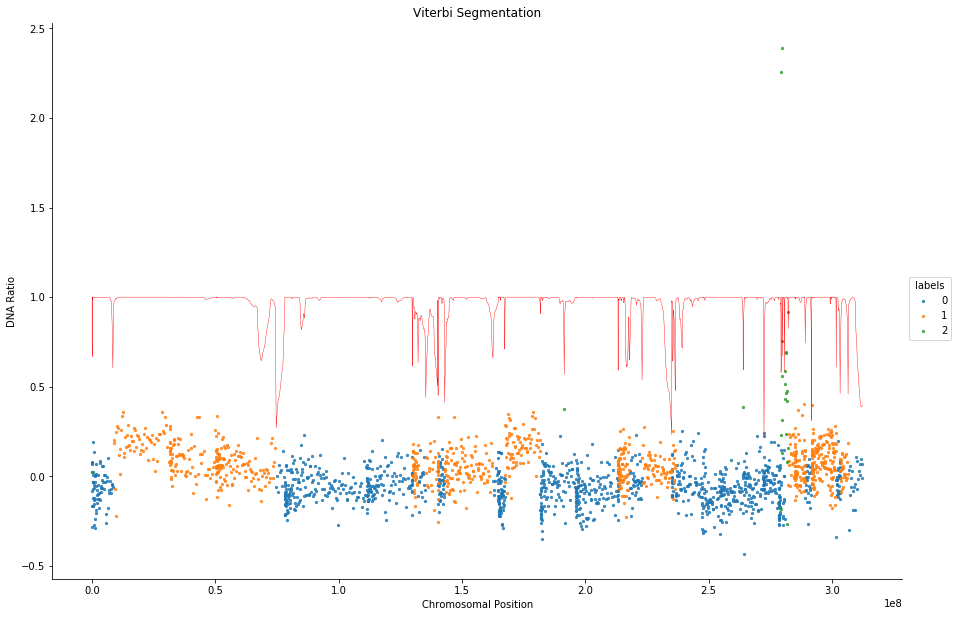

In [599]:
viterbi_plot(model, f_patient)
plt.plot(f_patient['chromosomal pos'], conf, c='r', linewidth=0.4)

The shape of the posterior shows us that the Viterbi path consists mostly of the states which have the highest probability or confidence. However, since the algorithm maximises over a sequence and not an individual point in time, the sequence chosen does not only consist of those states with the highest probability.

Also, because the BW algorithm finds the local optima, our choice of initial parameters (which places emphasis on self-transitions)

## Question 7

In [863]:
models = [compute_cycle(f_patient.ratio, 3) for i in range(1,11)]

In [864]:
samples = [i.sample(600) for i in models]

In [865]:
mean1 = []
mean2 = []
mean3 = []
for j in samples:
    models[0].fit([j])
    t = json.loads(models[0].to_json())
    mean1.append(t['states'][0]['distribution']['parameters'][0])
    mean2.append(t['states'][1]['distribution']['parameters'][0])
    mean3.append(t['states'][2]['distribution']['parameters'][0])

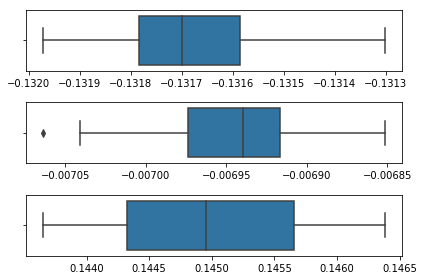

In [877]:
plt.subplot(311)
sns.boxplot(mean1)
plt.subplot(312)
sns.boxplot(mean2)
plt.subplot(313)
sns.boxplot(mean3)
plt.tight_layout()

In [875]:
var1 = []
var2 = []
var3 = []
for j in samples:
    models[0].fit([j])
    t = json.loads(models[0].to_json())
    var1.append(t['states'][0]['distribution']['parameters'][1])
    var2.append(t['states'][1]['distribution']['parameters'][1])
    var3.append(t['states'][2]['distribution']['parameters'][1])

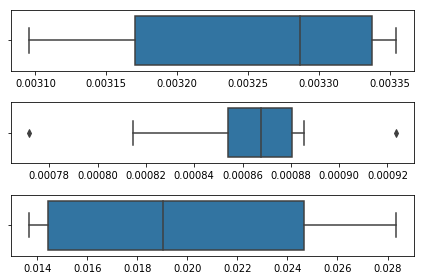

In [876]:
plt.subplot(311)
sns.boxplot(var1)
plt.subplot(312)
sns.boxplot(var2)
plt.subplot(313)
sns.boxplot(var3)
plt.tight_layout()

Since the variation in emission parameters is quite low, we can conclude that the models will converge to the local optimum with a high degree of confidence. 